In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import src.helper as dp

In [2]:
%load_ext autoreload
%autoreload 2

In [227]:
data = pd.read_csv('data/drugsComTrain_raw.tsv', sep='\t')

In [4]:
data.isnull().sum()

Unnamed: 0       0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [157]:
# drop rows with na for condition & rows with '</span> for condition' because only 0.5% of dataset is missing 
data = dp.drop_na(data)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159498 entries, 0 to 161296
Data columns (total 7 columns):
Unnamed: 0     159498 non-null int64
drugName       159498 non-null object
condition      159498 non-null object
review         159498 non-null object
rating         159498 non-null float64
date           159498 non-null object
usefulCount    159498 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 9.7+ MB


## Using PorterStemmer

In [159]:
# lowercase, stemming(porter), remove stopwrods, remove numbers & punctuation 
# added features: review length, sentiment score(using vader), get_dummy condition
data = dp.features_regression(data)

In [160]:
data.head()

,rating,usefulCount,review_clean,review_len,count_unique_word,compound
0,9.0,27,no side effect take combin bystol mg fish oil,17,9,-0.2960
1,8.0,192,son halfway fourth week intuniv becam concern ...,141,54,0.8603
2,5.0,17,use take anoth oral contracept pill cycl happi...,133,50,0.7645
3,8.0,10,first time use form birth control glad went pa...,89,26,0.7184
4,9.0,37,suboxon complet turn life around feel healthie...,134,51,0.9403


In [161]:
X_train, X_test, y_train, y_test = dp.split(data)

### Dumb Model Using Average

In [12]:
from sklearn.metrics import mean_squared_error

average = np.mean(y_train)
y_preds_d = np.full(y_test.shape, average)
rmse = np.sqrt(mean_squared_error(y_test, y_preds_d))
rmse

36.52909815255881

### Using Other Regression Models

*** tfidf with 10,000 max features ***

In [162]:
# tfidfvecotrizer with 10,000 max features
X_train_tfidf1, X_test_tfidf1 = dp.tfidf_vect(X_train, X_test, max_features=10000)

In [14]:
from scipy.sparse import hstack
from scipy.sparse import coo_matrix

In [163]:
# drop 'review_clean' column since it is vectorized
X_train_f1 = X_train.drop(columns=['review_clean'])
X_test_f1 = X_test.drop(columns=['review_clean'])

In [164]:
# adding other features to sparce matrix
X_train_f1 = hstack([X_train_tfidf1, coo_matrix(X_train_f1.iloc[:,:])])
X_test_f1 = hstack([X_test_tfidf1, coo_matrix(X_test_f1.iloc[:,:])])

In [223]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import src.rmse_calc as m

In [166]:
# linear regression
lr = LinearRegression()
y_pred_lr, rmse_lr = m.model_result(lr, X_train_f1, X_test_f1, y_train, y_test)
rmse_lr

31.7359785224869

In [167]:
# decision tree
dtr = DecisionTreeRegressor()
y_pred_dtr, rmse_dtr = m.model_result(dtr, X_train_f1, X_test_f1, y_train, y_test)
rmse_dtr

31.775425071640996

In [168]:
# gradient boosting
gbr = GradientBoostingRegressor()
y_pred_gbr, rmse_gbr = m.model_result(gbr, X_train_f1, X_test_f1, y_train, y_test)
rmse_gbr

31.503688943896446

In [169]:
# xgboost
xgbr = XGBRegressor()
y_pred_xgbr, rmse_xgbr = m.model_result(xgbr, X_train_f1, X_test_f1, y_train, y_test)
rmse_xgbr

28.950845631032966

In [265]:
resids = y_pred_xgbr-y_test
plt.scatter(np.arange(len(resids)), resids)
plt.title('Predictions Using XGBRegressor vs. y_test Residuals')


ValueError: operands could not be broadcast together with shapes (31900,) (53200,) 

*** trying out 20,000, 30,000, 40,000, 50,000 tfidf max features ***


In [170]:
X_train_tfidf2, X_test_tfidf2 = dp.tfidf_vect(X_train, X_test, max_features=20000)
X_train_tfidf3, X_test_tfidf3 = dp.tfidf_vect(X_train, X_test, max_features=30000)
X_train_tfidf4, X_test_tfidf4 = dp.tfidf_vect(X_train, X_test, max_features=40000)
X_train_tfidf5, X_test_tfidf5 = dp.tfidf_vect(X_train, X_test, max_features=50000)

In [171]:
# drop 'review_clean' column since it is vectorized
X_train_dropreview = X_train.drop(columns=['review_clean'])
X_test_dropreview = X_test.drop(columns=['review_clean'])

In [172]:
X_train_dropreview.head()

,rating,review_len,count_unique_word,compound
160029,7.0,61,21,0.8243
119242,10.0,106,42,-0.3400
101809,9.0,38,18,-0.7964
59952,1.0,27,11,-0.3089
59446,8.0,140,58,0.7939


In [173]:
# adding other features to sparce matrix
X_train_f2 = hstack([X_train_tfidf2, coo_matrix(X_train_dropreview.iloc[:,:])])
X_test_f2 = hstack([X_test_tfidf2, coo_matrix(X_test_dropreview.iloc[:,:])])

In [174]:
# xgboost w/ 20,000 max features
y_pred_xgbr2, rmse_xgbr2 = m.model_result(xgbr, X_train_f2, X_test_f2, y_train, y_test)
rmse_xgbr2

28.941734343422553

In [175]:
# adding other features to sparce matrix
X_train_f3 = hstack([X_train_tfidf3, coo_matrix(X_train_dropreview.iloc[:,:])])
X_test_f3 = hstack([X_test_tfidf3, coo_matrix(X_test_dropreview.iloc[:,:])])

In [176]:
# xgboost w/ 30,000 max features
y_pred_xgbr3, rmse_xgbr3 = m.model_result(xgbr, X_train_f3, X_test_f3, y_train, y_test)
rmse_xgbr3

28.954051387444164

In [177]:
# adding other features to sparce matrix
X_train_f4 = hstack([X_train_tfidf4, coo_matrix(X_train_dropreview.iloc[:,:])])
X_test_f4 = hstack([X_test_tfidf4, coo_matrix(X_test_dropreview.iloc[:,:])])

In [178]:
# xgboost w/ 40,000 max features
y_pred_xgbr4, rmse_xgbr4 = m.model_result(xgbr, X_train_f4, X_test_f4, y_train, y_test)
rmse_xgbr4

28.982861683823973

In [179]:
# adding other features to sparce matrix
X_train_f5 = hstack([X_train_tfidf5, coo_matrix(X_train_dropreview.iloc[:,:])])
X_test_f5 = hstack([X_test_tfidf5, coo_matrix(X_test_dropreview.iloc[:,:])])

In [180]:
# xgboost w/ 50,000 max features
y_pred_xgbr5, rmse_xgbr5 = m.model_result(xgbr, X_train_f5, X_test_f5, y_train, y_test)
rmse_xgbr5

29.08133987419329

In [39]:
# xgboost with 20,000 max features give the lowest rmse 28.941734343422553

In [215]:
stemmer_xgb = [28.950845631032966, 28.941734343422553, 28.954051387444164, 28.982861683823973, 29.08133987419329]

### Using Lemmatizer

In [132]:
data_lem = dp.drop_na(data)

In [133]:
# using WordNetLemmatizer
data_lem = dp.features_regression(data_lem)

In [134]:
X_train_lem, X_test_lem, y_train_lem, y_test_lem = dp.split(data_lem)

In [149]:
rmse_lem_xgb=[]
for i in range(10000, 60000, 10000):
    X_train_tfidf, X_test_tfidf = dp.tfidf_vect(X_train_lem, X_test_lem, max_features=i)
    X_train_l = hstack([X_train_tfidf, coo_matrix(X_train_lem.drop(columns=['review_clean']))])
    X_test_l = hstack([X_test_tfidf, coo_matrix(X_test_lem.drop(columns=['review_clean']))])
    y_pred_xgbr_l, rmse_xgbr_l = m.model_result(xgbr, X_train_l, X_test_l, y_train_lem, y_test_lem)
    rmse_lem_xgb.append(rmse_xgbr_l)


In [150]:
rmse_lem_xgb

[29.049585755417123,
 28.9685916503606,
 29.203455340549517,
 29.148556898387632,
 29.084863435990812]

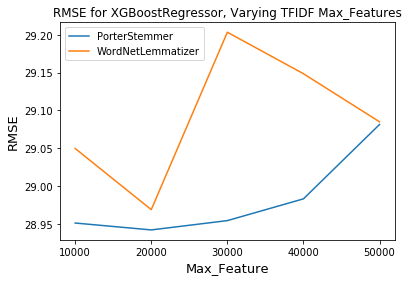

In [264]:
plt.plot(range(10000, 60000, 10000), stemmer_xgb)
plt.plot(range(10000, 60000, 10000), rmse_lem_xgb)

plt.xticks([i for i in range(10000, 60000, 10000)]);
plt.title('RMSE for XGBoostRegressor, Varying TFIDF Max_Features')
plt.xlabel('Max_Feature', fontsize=13)
plt.ylabel('RMSE', fontsize=13)
plt.legend(['PorterStemmer','WordNetLemmatizer'])

In [143]:
X_train_lem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127598 entries, 160029 to 123358
Data columns (total 5 columns):
rating               127598 non-null float64
review_clean         127598 non-null object
review_len           127598 non-null int64
count_unique_word    127598 non-null int64
compound             127598 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 5.8+ MB


In [151]:
X_train_tfidf, X_test_tfidf = dp.tfidf_vect(X_train_lem, X_test_lem, max_features=20000)
X_train_l = hstack([X_train_tfidf, coo_matrix(X_train_lem[['rating','review_len','count_unique_word','compound']])])
X_test_l = hstack([X_test_tfidf, coo_matrix(X_test_lem[['rating','review_len','count_unique_word','compound']])])

In [68]:
# grid search on stemmer, xgb, 10000 max features

from sklearn.model_selection import GridSearchCV
parameters = {
    'learning_rate': [0.06,0.1, 0.2, 0.3], 
    'max_depth':[5,6,7],
    'min_child_weight':[1,3,4],
    'subsample': [0.7, 1]
}

#{'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 1}
xgb_grid = GridSearchCV(xgbr, parameters, cv=2, verbose=3)
xgb_grid.fit(X_train_f2, y_train)



Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV] learning_rate=0.06, max_depth=5, min_child_weight=1, subsample=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.06, max_depth=5, min_child_weight=1, subsample=0.7, score=0.243, total=  11.5s
[CV] learning_rate=0.06, max_depth=5, min_child_weight=1, subsample=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s remaining:    0.0s


[CV]  learning_rate=0.06, max_depth=5, min_child_weight=1, subsample=0.7, score=0.237, total=  11.5s
[CV] learning_rate=0.06, max_depth=5, min_child_weight=1, subsample=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.0s remaining:    0.0s


[CV]  learning_rate=0.06, max_depth=5, min_child_weight=1, subsample=1, score=0.242, total=  12.1s
[CV] learning_rate=0.06, max_depth=5, min_child_weight=1, subsample=1 
[CV]  learning_rate=0.06, max_depth=5, min_child_weight=1, subsample=1, score=0.239, total=  13.5s
[CV] learning_rate=0.06, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  learning_rate=0.06, max_depth=5, min_child_weight=3, subsample=0.7, score=0.241, total=  11.5s
[CV] learning_rate=0.06, max_depth=5, min_child_weight=3, subsample=0.7 
[CV]  learning_rate=0.06, max_depth=5, min_child_weight=3, subsample=0.7, score=0.236, total=  11.4s
[CV] learning_rate=0.06, max_depth=5, min_child_weight=3, subsample=1 
[CV]  learning_rate=0.06, max_depth=5, min_child_weight=3, subsample=1, score=0.243, total=  12.1s
[CV] learning_rate=0.06, max_depth=5, min_child_weight=3, subsample=1 
[CV]  learning_rate=0.06, max_depth=5, min_child_weight=3, subsample=1, score=0.241, total=  12.1s
[CV] learning_rate=0.06, max_depth=5, min_c

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 32.9min finished


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=0.5, booster=None,
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=0,
                                    num_parallel_tree=1, random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method=None, validate_parameters=False,
                                    verbosity=None),
       

In [69]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_) #no sentiment

0.3233801028955129
{'learning_rate': 0.3, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 1}


In [232]:
xgbr_op = XGBRegressor(learning_rate=0.3, 
                    max_depth=7, 
                    min_child_weight=3,
                    subsample=1)
xgbr_op.fit(X_train_f2, y_train)


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.3, max_delta_step=0, max_depth=7,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

### Save tfidfvecotrize and xgbregressor to pickle

In [233]:
# save model to disk
import pickle

filename = 'finalized_model.sav'
pickle.dump(xgbr_op, open(filename, 'wb'))

In [234]:
load_model = pickle.load(open(filename, 'rb'))

In [235]:
y_pred_xgbr_op = load_model.predict(X_test_f2)

In [236]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgbr_op))

In [237]:
rmse

28.819353814345735

In [247]:
tfidf = TfidfVectorizer(analyzer = 'word',
                       tokenizer = None,
                       preprocessor = None,
                       stop_words = None,
                       ngram_range=(1,2),
                       max_features=20000)
tfidf.fit(X_train['review_clean'])

TfidfVectorizer(max_features=20000, ngram_range=(1, 2))

In [248]:
pickle.dump(tfidf, open('tfidf.pickle','wb'))

In [249]:
tfidf = pickle.load(open('tfidf.pickle','rb'))

### Testing on Test Set

In [250]:
data_test = pd.read_csv('data/drugsComTest_raw.tsv', sep='\t')

In [251]:
data_t = dp.drop_na(data_test)
data_t = dp.features_regression(data_t)

In [252]:
data_t.head()

,rating,usefulCount,review_clean,review_len,count_unique_word,compound
0,10.0,22,tri antidepress year citalopram fluoxetin amit...,68,34,-0.4596
1,8.0,17,son crohn diseas done well asacol no complaint...,51,25,0.0736
2,9.0,3,quick reduct symptom,4,3,0.0000
3,9.0,35,contrav combin drug use alcohol smoke opioid c...,143,60,0.7086
4,9.0,4,birth control one cycl read review type simila...,149,53,0.9559


In [253]:
X = data_t.drop(columns=['usefulCount'])
y = data_t['usefulCount']

In [254]:
X_tfidf = tfidf.transform(X['review_clean'])

In [259]:
X_test_stacked = hstack([X_tfidf, coo_matrix(X[['rating','review_len','count_unique_word','compound']])])
y_test = load_model.predict(X_test_stacked)

In [260]:
rmse = np.sqrt(mean_squared_error(y, y_test))
rmse

29.225034275337425